In [10]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import json
import transformers
from pathlib import Path

# Loading the Data

In [11]:
def read_squad(path):
    """
    Loads the data from the json file into parallel lists of contexts, questions, answers, and another list to indicate
    whether the question is answerable or not. Note that the context may report multiple times, as one context may have
    several questions based on it.
    
    Input: path to the json data file
    
    Returns:
        contexts(str): passage which contains the answer to the question
        questions(str): question to be asked to the model
        answers(dict): answer to the corresponding question along with the index at which it starts.
        is_impossible(bool): tells whether the question is answerable or not
    """
    
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    is_impossible_list=[]
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                answerable = qa['is_impossible']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
                    is_impossible_list.append(answerable)
                    
    return contexts, questions, answers, is_impossible_list

train_contexts, train_questions, train_answers, train_is_impossible = read_squad('squad-data/train-v2.0.json')
val_contexts, val_questions, val_answers, val_is_impossible = read_squad('squad-data/dev-v2.0.json')

Interestingly, the count of questions that are impossible to answer is 0 despite it being mentioned in the dataset.

In [12]:
count_impossible = 0
for i, j in zip(val_is_impossible, train_is_impossible):
    if (i == True) or (j==True):
        count_impossible+=1
count_impossible

0

# Preprocessing the Data

The below function adds an end index which gives the position of the token at which the answer ends. Sometimes the answers in SQuAD are off by 1 or 2 indices, so we also adjust for that in the function below.

In [13]:
def add_end_idx(answers, contexts):
    """
    Input:
        answers(list): answers that correspond to a particular question.
        contexts(list): context which contains the corresponding answer.
    Output:
        Adds an end index answer['answer_end'] which corresponds to the token at which the answer ends
        and also adjusts indices to ensure they are correct.
        
    """
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

### Tokenizing the input
Now we need to tokenize our context/question pairs. Tokenizers accept parallel lists of sequences and encode them together as sequence pairs.
The output of these encodings is of the form: [CLS] + tokenized_context_string + [SEP] tokenized_question_string + [SEP]

In [14]:
from transformers import AlbertTokenizerFast
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

### Converting character start/end positions to token start/end positions

In [15]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

# Putting the preprocessed Data into a Pytorch Dataset class

In [16]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [63]:
test_dataset_size = int(0.5 * len(val_dataset))
val_dataset, test_dataset = val_dataset[:test_dataset_size], val_dataset[test_dataset_size + 1:]

# Model

In order to define any custom pytorch model, we must do two things: define an __init__() function which contains all the parameters of the model and a forward() function which defines the flow of forward propogation using the model parameters.

In [68]:
class AlBertQA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = transformers.AlbertForQuestionAnswering.from_pretrained(config)

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs, return_dict=False)

model = AlBertQA('albert-base-v2')


Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-xlarge-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRA

In [69]:
#Printing the model architecture
model

AlBertQA(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=2048, out_features=2048, bias=True)
                  (key): Linear(in_features=2048, out_features=2048, bias=True)
        

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

# Training

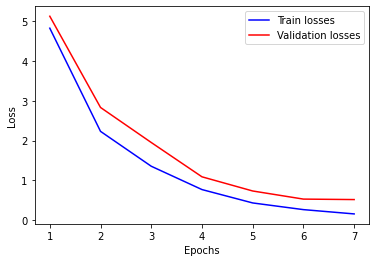

In [87]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
optim = Adam(model.parameters(), lr=5e-5)

train_losses = [0]*7
val_losses = [0]*7

for epoch in range(7):
    model.train() 
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        train_losses[epoch]= loss.item()
    #evaluate on val set
    model.eval()
    val_batch = next(iter(val_dataset))
    input_ids = val_batch['input_ids'].to(device)
    attention_mask = val_batch['attention_mask'].to(device)
    start_positions = val_batch['start_positions'].to(device)
    end_positions = val_batch['end_positions'].to(device)
    val_outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    val_loss = val_outputs[0]
    val_losses[epoch] = val_loss.item()
    
model.eval()

train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
epoch = np.array([1,2,3,4,5,6,7])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epoch, train_losses_np, '-b', label = 'Train losses')
plt.plot(epoch, val_losses_np, '-r', label = 'Validation losses')
plt.legend()
plt.show()

In [88]:
model_path = 'models/AlbertQACustom'
torch.save(model.state_dict(), model_path)

# Testing the Model - F1 score

In [89]:
#In order to test the performance of our model, we compute the F1 score on it
test_dataloader = Dataloader(test_dataset, batch_size = len(test_dataset))
output_ = model(next(iter(test_dataloader)))
output_batch = (torch.argmax(output_[1]), torch.argmax(output_[2])) 
ground_truth = (test_data['answer_start'], test_data['answer_end'])
import collections
def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()
def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1
score = compute_f1(ground_truth, output_batch)
score = "{:.3f}".format(score)
print("The F1 score of the model on the test set is: ", score)

The F1 score of the model on the test set is:  84.126


## Testing the Model on our own inputs


In [90]:
context_1 = "Parth Sharma is a student at DTU. He was born on 28th september 2000. \
His mother was born on 23rd april. He loves watching tv shows and playing table tennis."
question_1 = "When was Parth Sharma born?"
input_ids = tokenizer.encode(context_1, question_1)
print('Input ids', input_ids)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
inputs = torch.tensor([input_ids])
start_scores, end_scores = model(inputs, token_type_ids=torch.tensor([token_type_ids]))
all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
print('Answer:', answer)

Answer: 28th september 2000


In [91]:
context_2 = "Nishant Soni is a student of Delhi Technological University in Bawana, and lives in Rajouri Garden. \
He loves going to Connaught place and eat at the restaurants there. "
question_2 = "Where does Nishant Soni live?"
input_ids = tokenizer.encode(context_2, question_2)
print('Input ids', input_ids)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
inputs = torch.tensor([input_ids])
start_scores, end_scores = model(inputs, token_type_ids=torch.tensor([token_type_ids]))
all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
print('Answer:', answer)

Answer: Rajouri Garden
